# 1. Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
pd.set_option("mode.chained_assignment",None)
import numpy as np
import os
import sys

from plotnine import *
import scipy

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# 2. Load data

In [2]:
data_filepath = r"/Users/gardy/Documents/GardyL/Statistiques/Stats Marie B/2022/EPICEA-database-article_V4_ranking only.xlsx"
patients_df = pd.read_excel(data_filepath)
print(patients_df)

    Nom  Num  Age  sexe  EME_DE_NOVO  Ranking_score Ranking_time
0    SA    1   79     1            1              2      pre-EME
1    QD    2   80     1            1              2      pre-EME
2    VA    3   59     0            1              4      pre-EME
3    AC    4   69     0            1              3      pre-EME
4    PA    5   75     1            1              0      pre-EME
..   ..  ...  ...   ...          ...            ...          ...
427  RO  105   33     0            0              0          M12
428  MR  106   73     0            0              3          M12
429  AD  107   36     1            0              1          M12
430  AA  108   17     1            0              1          M12
431  TG  109   57     0            0              3          M12

[432 rows x 7 columns]


# 3. Reorder data

In [3]:
patients_df['EME_DE_NOVO'][patients_df['EME_DE_NOVO'] == 0] = "NISE"
patients_df['EME_DE_NOVO'][patients_df['EME_DE_NOVO'] == 1] = "NOSE"

patients_df['Ranking_time'][patients_df['Ranking_time'] == "pre-EME"] = np.int64(0)#"1. pre-EME"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M1"] = np.int64(1)#"2. M1"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M3"] = np.int64(2)#"3. M3"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M12"] = np.int64(3) #"4. M12"

# 4.Plot data
## 4.1. Boxplots
### 4.1.1. NISE vs NOSE vs TIME

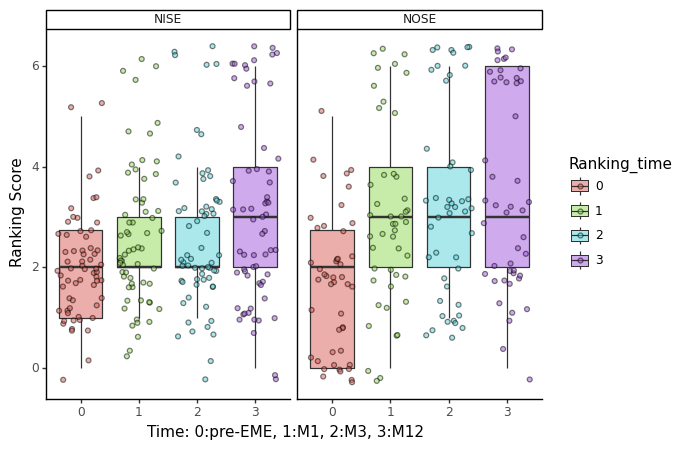

<ggplot: (701187250)>

In [4]:
boxplot_1 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('EME_DE_NOVO', ncol = 2)
    )

boxplot_1

## 4.2. Linear regressions

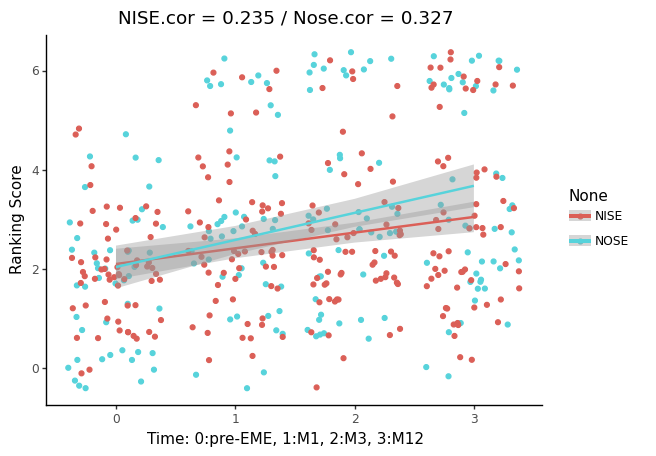

<ggplot: (702548215)>

In [6]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['EME_DE_NOVO'])

### Calculate Pearson correlations
r_NISE = np.round(np.corrcoef(x[z=="NISE"], y[z=="NISE"])[0,1],3)
r_NOSE = np.round(np.corrcoef(x[z=="NOSE"], y[z=="NOSE"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter()
    + geom_smooth(method='lm')
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'NISE.cor = {r_NISE} / Nose.cor = {r_NOSE}')             
    + theme_classic()          
    )

lreg_1

# 5. Inferential statistics

## 5.1. Test interactions between independant variables

There is no interaction between EME_DE_NOVO (NOSE/NISE) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score evolves between "pre-EME" and "M12", in similar proportions (at the same "speed") for all patients, either NOSE or NISE. Nevertheless, the scores between NOSE and NISE are different. Thus, this difference is preserved over time.

In [7]:
model = ols("""Ranking_score ~ EME_DE_NOVO + Ranking_time +
               EME_DE_NOVO:Ranking_time""", data=patients_df).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
EME_DE_NOVO,8.488809,1.0,3.324977,6.893887e-02
Ranking_time,106.062500,3.0,13.847855,1.246491e-08
EME_DE_NOVO:Ranking_time,11.437675,3.0,1.493339,2.157267e-01
Residual,1082.490182,424.0,NaN,NaN


In [8]:
md = smf.mixedlm("Ranking_score ~ EME_DE_NOVO + Ranking_time + EME_DE_NOVO:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Ranking_score
No. Observations:        432            Method:                    REML         
No. Groups:              108            Scale:                     0.6706       
Min. group size:         4              Log-Likelihood:            -665.5287    
Max. group size:         4              Converged:                 Yes          
Mean group size:         4.0                                                    
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              2.016    0.203  9.936 0.000  1.618  2.414
EME_DE_NOVO[T.NOSE]                   -0.277    0.311 -0.891 0.373 -0.886  0.332
Ranking_time[T.1]                      0.597    0.

## 5.2. Mixed model: NISE vs NOSE vs Ranking_time

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("Ranking_score ~ EME_DE_NOVO + Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Ranking_score
No. Observations:   432     Method:             REML         
No. Groups:         108     Scale:              0.7000       
Min. group size:    4       Log-Likelihood:     -671.8473    
Max. group size:    4       Converged:          Yes          
Mean group size:    4.0                                      
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.777    0.195  9.127 0.000  1.396  2.159
EME_DE_NOVO[T.NOSE] 0.283    0.279  1.017 0.309 -0.263  0.830
Ranking_time[T.1]   0.889    0.114  7.807 0.000  0.666  1.112
Ranking_time[T.2]   0.972    0.114  8.539 0.000  0.749  1.195
Ranking_time[T.3]   1.352    0.114 11.874 0.000  1.129  1.575
Group Var           1.875    0.388                           



## 5.3. Post-hoc

In [10]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"], patients_df["Ranking_time"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.8889,0.0003,0.3256,1.4522,True
0,2,0.9722,0.0001,0.4089,1.5355,True
0,3,1.3519,0.0,0.7886,1.9151,True
1,2,0.0833,0.9811,-0.48,0.6466,False
1,3,0.463,0.1484,-0.1003,1.0263,False
2,3,0.3796,0.3052,-0.1837,0.9429,False


## Explanation of the results of the mixed effects model and post-hoc

### Patients NISE
- Patients NISE have an average ranking of 1.777 at time "pre-EME". _**`Total: 1.777`**_.
- Patients NISE have an average ranking of 1.777 + 0.889 at time "M1". _**`Total: 2.666`**_ 
- Patients NISE have an average ranking of 1.777 + 0.972 at time "M3". _**`Total: 2.75`**_
- Patients NISE have an average ranking of 1.777 + 1.352 at time "M12". _**`Total: 3.129`**_ 

### Patients NOSE
- Patients NOSE have an average ranking of 1.777 + 0.283 at time "pre-EME". _**`Total: 2.06`**_
- Patients NOSE have an average ranking of 1.777 + 0.283 + 0.889 at time "M1". _**`Total: 2.95`**_
- Patients NOSE have an average ranking of 1.777 + 0.283 + 0.972 at time "M3".  _**`Total: 3.032`**_
- Patients NOSE have an average ranking of 1.777 + 0.283 + 1.352 at time "M12". _**`Total: 3.412`**_

### Post-hoc results
As time has the same impact on ranking for NOSE and NISE, we evaluated its effect for both categories together.

- For NISE and NOSE together, ranking at pre-EME is different from ranking at M1, M2 and M3. 
- There is no difference in ranking between M1 and M2, M1 and M3 or M2 and M3.

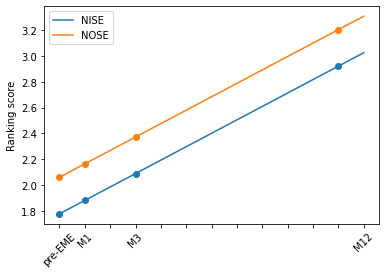

In [12]:
x_vals = np.arange(0,13)

intercept_NISE = 1.777
slope_NISE = (3.129-intercept_NISE) / 13 # 13 month between pre-EME and M12
#NISE_line = intercept_NISE + slope_NISE * x_vals
NISE_line = np.arange(intercept_NISE, intercept_NISE+slope_NISE*13, slope_NISE)

intercept_NOSE = 2.06
slope_NOSE = (3.412-2.06) / 13 # 13 month between pre-EME and M12
#NOSE_line  = intercept_NOSE + slope_NOSE * x_vals
NOSE_line = np.arange(intercept_NOSE, intercept_NOSE+slope_NOSE*13, slope_NOSE)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, NISE_line)
ax.plot(x_vals, NOSE_line)
ax.scatter([0,1,3,11], [NISE_line[0], NISE_line[1], NISE_line[3], NISE_line[11]])
ax.scatter([0,1,3,11], [NOSE_line[0], NOSE_line[1], NOSE_line[3], NOSE_line[11]])
ax.set_xticks(np.arange(0,13),rotation=90)
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "", "", "", "", "", "M12"],  rotation = 45);
ax.legend(["NISE","NOSE"])